To start, we import items then read in the data. 


In [6]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv

test_data = pd.read_csv("C:\\Users\\nicke\\Downloads\\house_price_data\\test.csv")
train_data = pd.read_csv("C:\\Users\\nicke\\Downloads\\house_price_data\\train.csv")

all_data = pd.concat((test_data.loc[:,:], train_data.loc[:, :]))
all_data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN        Gar2   12500   
2         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4         HLS    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      6   2010        WD         Normal        NaN  
1      6   2010        WD         Normal        NaN  
2      3   2010        WD         Normal        NaN  
3      6   2010        WD         Normal        NaN  
4      1   2010        WD         Normal        NaN  

[5 rows x 81 columns]

Let's next look closer at the feature we're targeting...

In [8]:
all_data["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

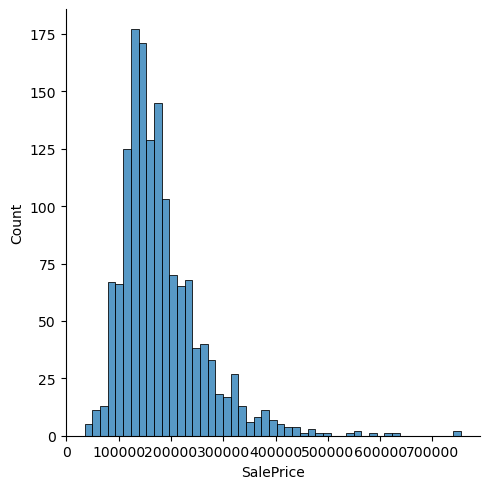

In [9]:
sns.displot(all_data['SalePrice'])

We notice that there may be some outliers. We can next drop some columns from the dataset.


In [11]:
# Dropping columns for both train and test dataset
#train_data = train_data.drop("Id", axis=1)
#test_data = test_data.drop("Id", axis=1)
train_data = train_data.drop(["Street", "Utilities"], axis=1)
test_data = test_data.drop(["Street", "Utilities"], axis=1)


Let's now plot GrLivArea and SalePrice

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

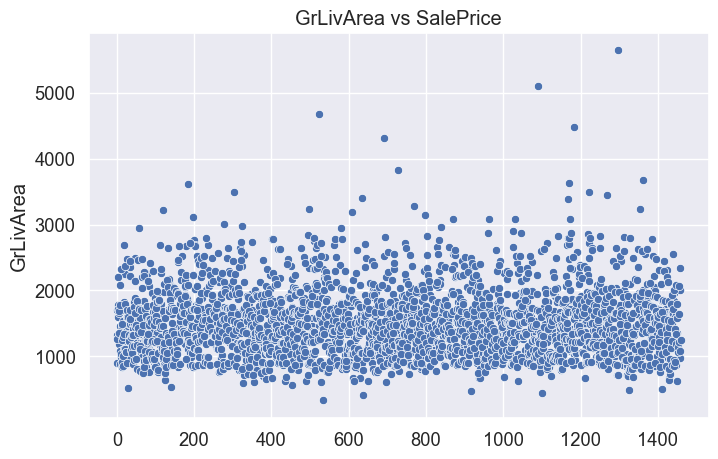

In [13]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(all_data["GrLivArea"])
plt.title("GrLivArea vs SalePrice")

In [14]:
clear_data = train_data.drop(train_data[(train_data['GrLivArea']>4500)].index)
# Concatenate all data together - both train and test
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)

In [15]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

mean  median  avg_mean_median
Neighborhood                                    
Blmngtn       46.900000    43.0        44.950000
Blueste       27.300000    24.0        25.650000
BrDale        21.500000    21.0        21.250000
BrkSide       55.789474    51.0        53.394737
ClearCr       88.150000    80.5        84.325000
CollgCr       71.336364    70.0        70.668182
Crawfor       69.951807    70.0        69.975904
Edwards       66.910112    65.0        65.955056
Gilbert       74.207207    64.0        69.103604
IDOTRR        62.241379    60.0        61.120690
MeadowV       25.606061    21.0        23.303030
Mitchel       75.144444    74.0        74.572222
NAmes         75.210667    73.0        74.105333
NPkVill       28.142857    24.0        26.071429
NWAmes        81.517647    80.0        80.758824
NoRidge       91.629630    89.0        90.314815
NridgHt       84.184049    92.0        88.092025
OldTown       61.777293    60.0        60.888646
SWISU         59.068182    60.0        59.534091
Sawyer        74.551020    72.0        73.275510
SawyerW       70.669811    67.0        68.834906
Somerst       64.549383    72.5        68.524691
StoneBr       62.173913    60.0        61.086957
Timber        81.157895    82.0        81.578947
Veenker       72.000000    80.0        76.000000

In [152]:
# Required imports
!pip install pandas numpy scikit-learn lazypredict
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
import lazypredict

# Load the data
try:
    test_data = pd.read_csv("C:\\Users\\nicke\\Downloads\\house_price_data\\test.csv")
    train_data = pd.read_csv("C:\\Users\\nicke\\Downloads\\house_price_data\\train.csv")

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    raise

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Define outlier bounds - wrapped in a function with error handling
def remove_outliers(datagram, feature):
    if feature not in datagram.columns:
        print(f"Warning: '{feature}' column not found in the dataset")
        return datagram
    
    Q1 = datagram[feature].quantile(0.25)
    Q3 = datagram[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return datagram[
        (datagram[feature] >= lower_bound) & (datagram[feature] <= upper_bound)
    ]
#define qualitative columns
qualitative_columns = train_data.select_dtypes(include=['object']).columns.tolist()

# Define numeric columns
numeric_cols = [col for col in train_data.columns if col not in qualitative_columns and col != 'Id']


# Fill NA values in numeric columns with their respective medians
for col in numeric_cols:
    if col in train_data.columns:
        if train_data[col].dtype in ['int64', 'float64']:
            train_data[col] = train_data[col].fillna(train_data[col].median())
            if col in test_data.columns:
                test_data[col] = test_data[col].fillna(train_data[col].median())

label_encoders = {}
# Fill missing values in categorical columns with "NA" before encoding
for col in qualitative_columns:
    if col in train_data.columns:
        train_data[col] = train_data[col].fillna("NA")
        if col in test_data.columns:
            test_data[col] = test_data[col].fillna("NA")

# Use OrdinalEncoder to handle unseen categories
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_data[qualitative_columns] = encoder.fit_transform(train_data[qualitative_columns])
test_data[qualitative_columns] = encoder.transform(test_data[qualitative_columns])

# Convert to int if necessary
train_data[qualitative_columns] = train_data[qualitative_columns].astype(int)
test_data[qualitative_columns] = test_data[qualitative_columns].astype(int)

# Fill any remaining NaN values with -1
train_data.fillna(-1, inplace=True)
test_data.fillna(-1, inplace=True)


# First, fill missing values in categorical columns
for col in qualitative_columns:
    if col in train_data.columns:
        # Fill missing values with mode (most frequent value)
        mode_val = train_data[col].mode()[0]
        train_data[col] = train_data[col].fillna(mode_val)
        if col in test_data.columns:
            test_data[col] = test_data[col].fillna(mode_val)

# Then apply LabelEncoder
for col in qualitative_columns:
    if col in train_data.columns and train_data[col].dtype == "object":
        try:
            le = LabelEncoder()
            train_data[col] = le.fit_transform(train_data[col].astype(str))
            if col in test_data.columns:
                test_data[col] = le.transform(test_data[col].astype(str))
            label_encoders[col] = le
        except Exception as e:
            print(f"Error processing column {col}: {e}")



print(test_data)

print("\nProcessing complete. Final train data shape:", train_data.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)
        Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
0     1461          20         2        80.00    11622       1      1   
1     1462          20         3        81.00    14267       1      1   
2     1463          60         3        74.00    13830       1      1   
3     1464          60         3        78.00     9978       1      1   
4     1465         120         3        43.00     5005       1      1   
...    ...         ...       ...          ...      ...     ...    ...   
1454  2915         160         4        21.00     1936       1      1   
1455  2916         160         4        21.00     1894       1      1   
1456  2917          20         3       160.00    20000       1      1   
1457  2918          85         3        62.00    10441       1      1   
1458  2919          60         3        74.00     9627       1      1   

      LotShape  LandContour  Utilities  ...  ScreenPorch  PoolArea

Updates as of 3/22/2025 
Model Selection


In [154]:

# Features
Inputs = [col for col in train_data.columns if col != "SalePrice" and col != "Id"]
Output = ["SalePrice"]

#train_X = train_data[Inputs]
#train_y = train_data[Output].values.ravel()

#test_X = test_data[Inputs]


X = train_data[Inputs]
y = train_data[Output].values.ravel()

X.fillna(-1, inplace=True)
#scale data with the standard scaler
scaler = StandardScaler()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, random_state=38)

# Convert categorical columns to numeric
train_X = train_X.apply(pd.to_numeric, errors='coerce')
test_X = test_X.apply(pd.to_numeric, errors='coerce')
X_scaled = scaler.fit_transform(train_X)

clf = LazyRegressor()
models, predictions = clf.fit(train_X, test_X, train_y, test_y)
print(models)

 98%|█████████▊| 41/42 [00:15<00:00,  3.08it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3159
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 72
[LightGBM] [Info] Start training from score 180892.338185


100%|██████████| 42/42 [00:16<00:00,  2.57it/s]

                                    Adjusted R-Squared  \
Model                                                    
XGBRegressor                                      0.77   
HistGradientBoostingRegressor                     0.76   
RandomForestRegressor                             0.75   
LGBMRegressor                                     0.75   
GradientBoostingRegressor                         0.75   
ElasticNet                                        0.72   
PassiveAggressiveRegressor                        0.72   
TweedieRegressor                                  0.71   
BaggingRegressor                                  0.71   
ExtraTreesRegressor                               0.70   
HuberRegressor                                    0.68   
OrthogonalMatchingPursuit                         0.67   
OrthogonalMatchingPursuitCV                       0.66   
KNeighborsRegressor                               0.64   
LarsCV                                            0.64   
DecisionTreeRe

We picked the Gradient Boosting Regressor

In [156]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, random_state=38)
train_X = train_data[Inputs].apply(pd.to_numeric, errors='coerce')
train_y = train_data[Output].apply(pd.to_numeric, errors='coerce').values.ravel()
#test_X = test_X.drop(columns="Id", axis = 1, inplace=True)
print(test_X.head)
#print("Max: ", y.max)
#print("Min: ", y.min)

<bound method NDFrame.head of       MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
464           20         3        60.00     8430       1      1         3   
1310          20         3       100.00    17500       1      1         3   
193          160         4        24.00     2522       1      1         3   
1394         120         3        53.00     4045       1      1         3   
1248          75         4        60.00     9600       1      0         3   
...          ...       ...          ...      ...     ...    ...       ...   
267           75         3        60.00     8400       1      1         3   
1186         190         3       107.00    10615       1      1         0   
904           20         3        69.00     6173       1      1         0   
1284          50         3        50.00     9638       1      1         3   
796           20         3        71.00     8197       1      1         3   

      LandContour  Utilities  LotConfig  ... 

In [157]:
#new imports 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, max_error, roc_curve, auc

#CREATE the model 
gbrModel = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.1, max_depth=4, random_state=42)

#test_X = test_X.drop(columns="Id", axis = 1, inplace=True)
# Train the model on the training data
gbrModel.fit(train_X, train_y)

#test_X = test_X.drop(columns="Id", axis = 1, inplace=True)
# Make predictions on the test data
y_pred = gbrModel.predict(test_X)


# Evaluate the model's performance using Mean Squared Error (MSE)
mse = mean_squared_error(test_y, y_pred)
print(f"Mean Squared Error: {mse}")

maxerror = max_error(test_y, y_pred)
print(f"Max Error: {maxerror}")
#The max_error function computes the maximum residual error, a metric that captures the worst case error between 
#the predicted value and the true value.


#-----------------------------------
feature_names = train_X.columns
count = 0;
#Print the feature importances (in case of multivariate data)
for feature_name in feature_names:
    print(f"Feature Importances: {feature_name}, {gbrModel.feature_importances_[count]}")
    count =+ 1
#print(f"Feature Importances: {feature_names}, {gbrModel.feature_importances_}")

Mean Squared Error: 0.2103914089557086
Max Error: 3.946256675204495
Feature Importances: MSSubClass, 0.00014260448641345794
Feature Importances: MSZoning, 0.00339450719995899
Feature Importances: LotFrontage, 0.00339450719995899
Feature Importances: LotArea, 0.00339450719995899
Feature Importances: Street, 0.00339450719995899
Feature Importances: Alley, 0.00339450719995899
Feature Importances: LotShape, 0.00339450719995899
Feature Importances: LandContour, 0.00339450719995899
Feature Importances: Utilities, 0.00339450719995899
Feature Importances: LotConfig, 0.00339450719995899
Feature Importances: LandSlope, 0.00339450719995899
Feature Importances: Neighborhood, 0.00339450719995899
Feature Importances: Condition1, 0.00339450719995899
Feature Importances: Condition2, 0.00339450719995899
Feature Importances: BldgType, 0.00339450719995899
Feature Importances: HouseStyle, 0.00339450719995899
Feature Importances: OverallQual, 0.00339450719995899
Feature Importances: OverallCond, 0.00339450

In [158]:
print(test_X.columns)


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Our second model is the XGBRegressor

Mean Squared Error (MSE): 30910430.8921
R-squared: 0.9952


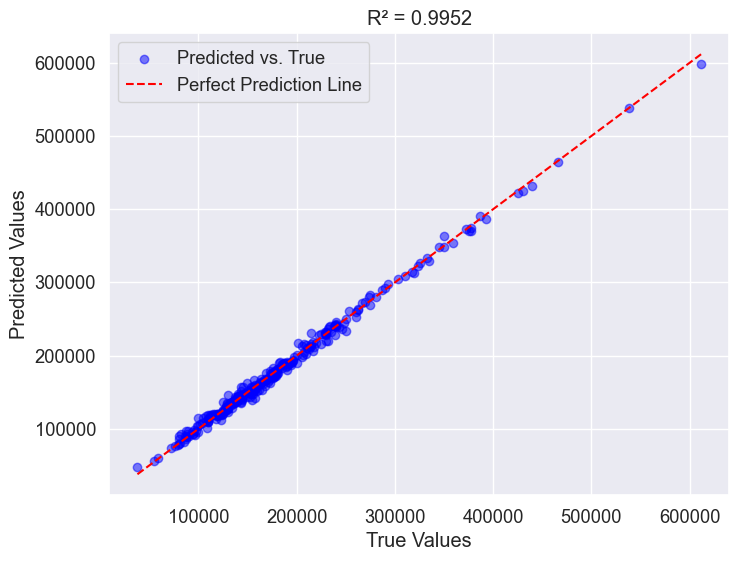

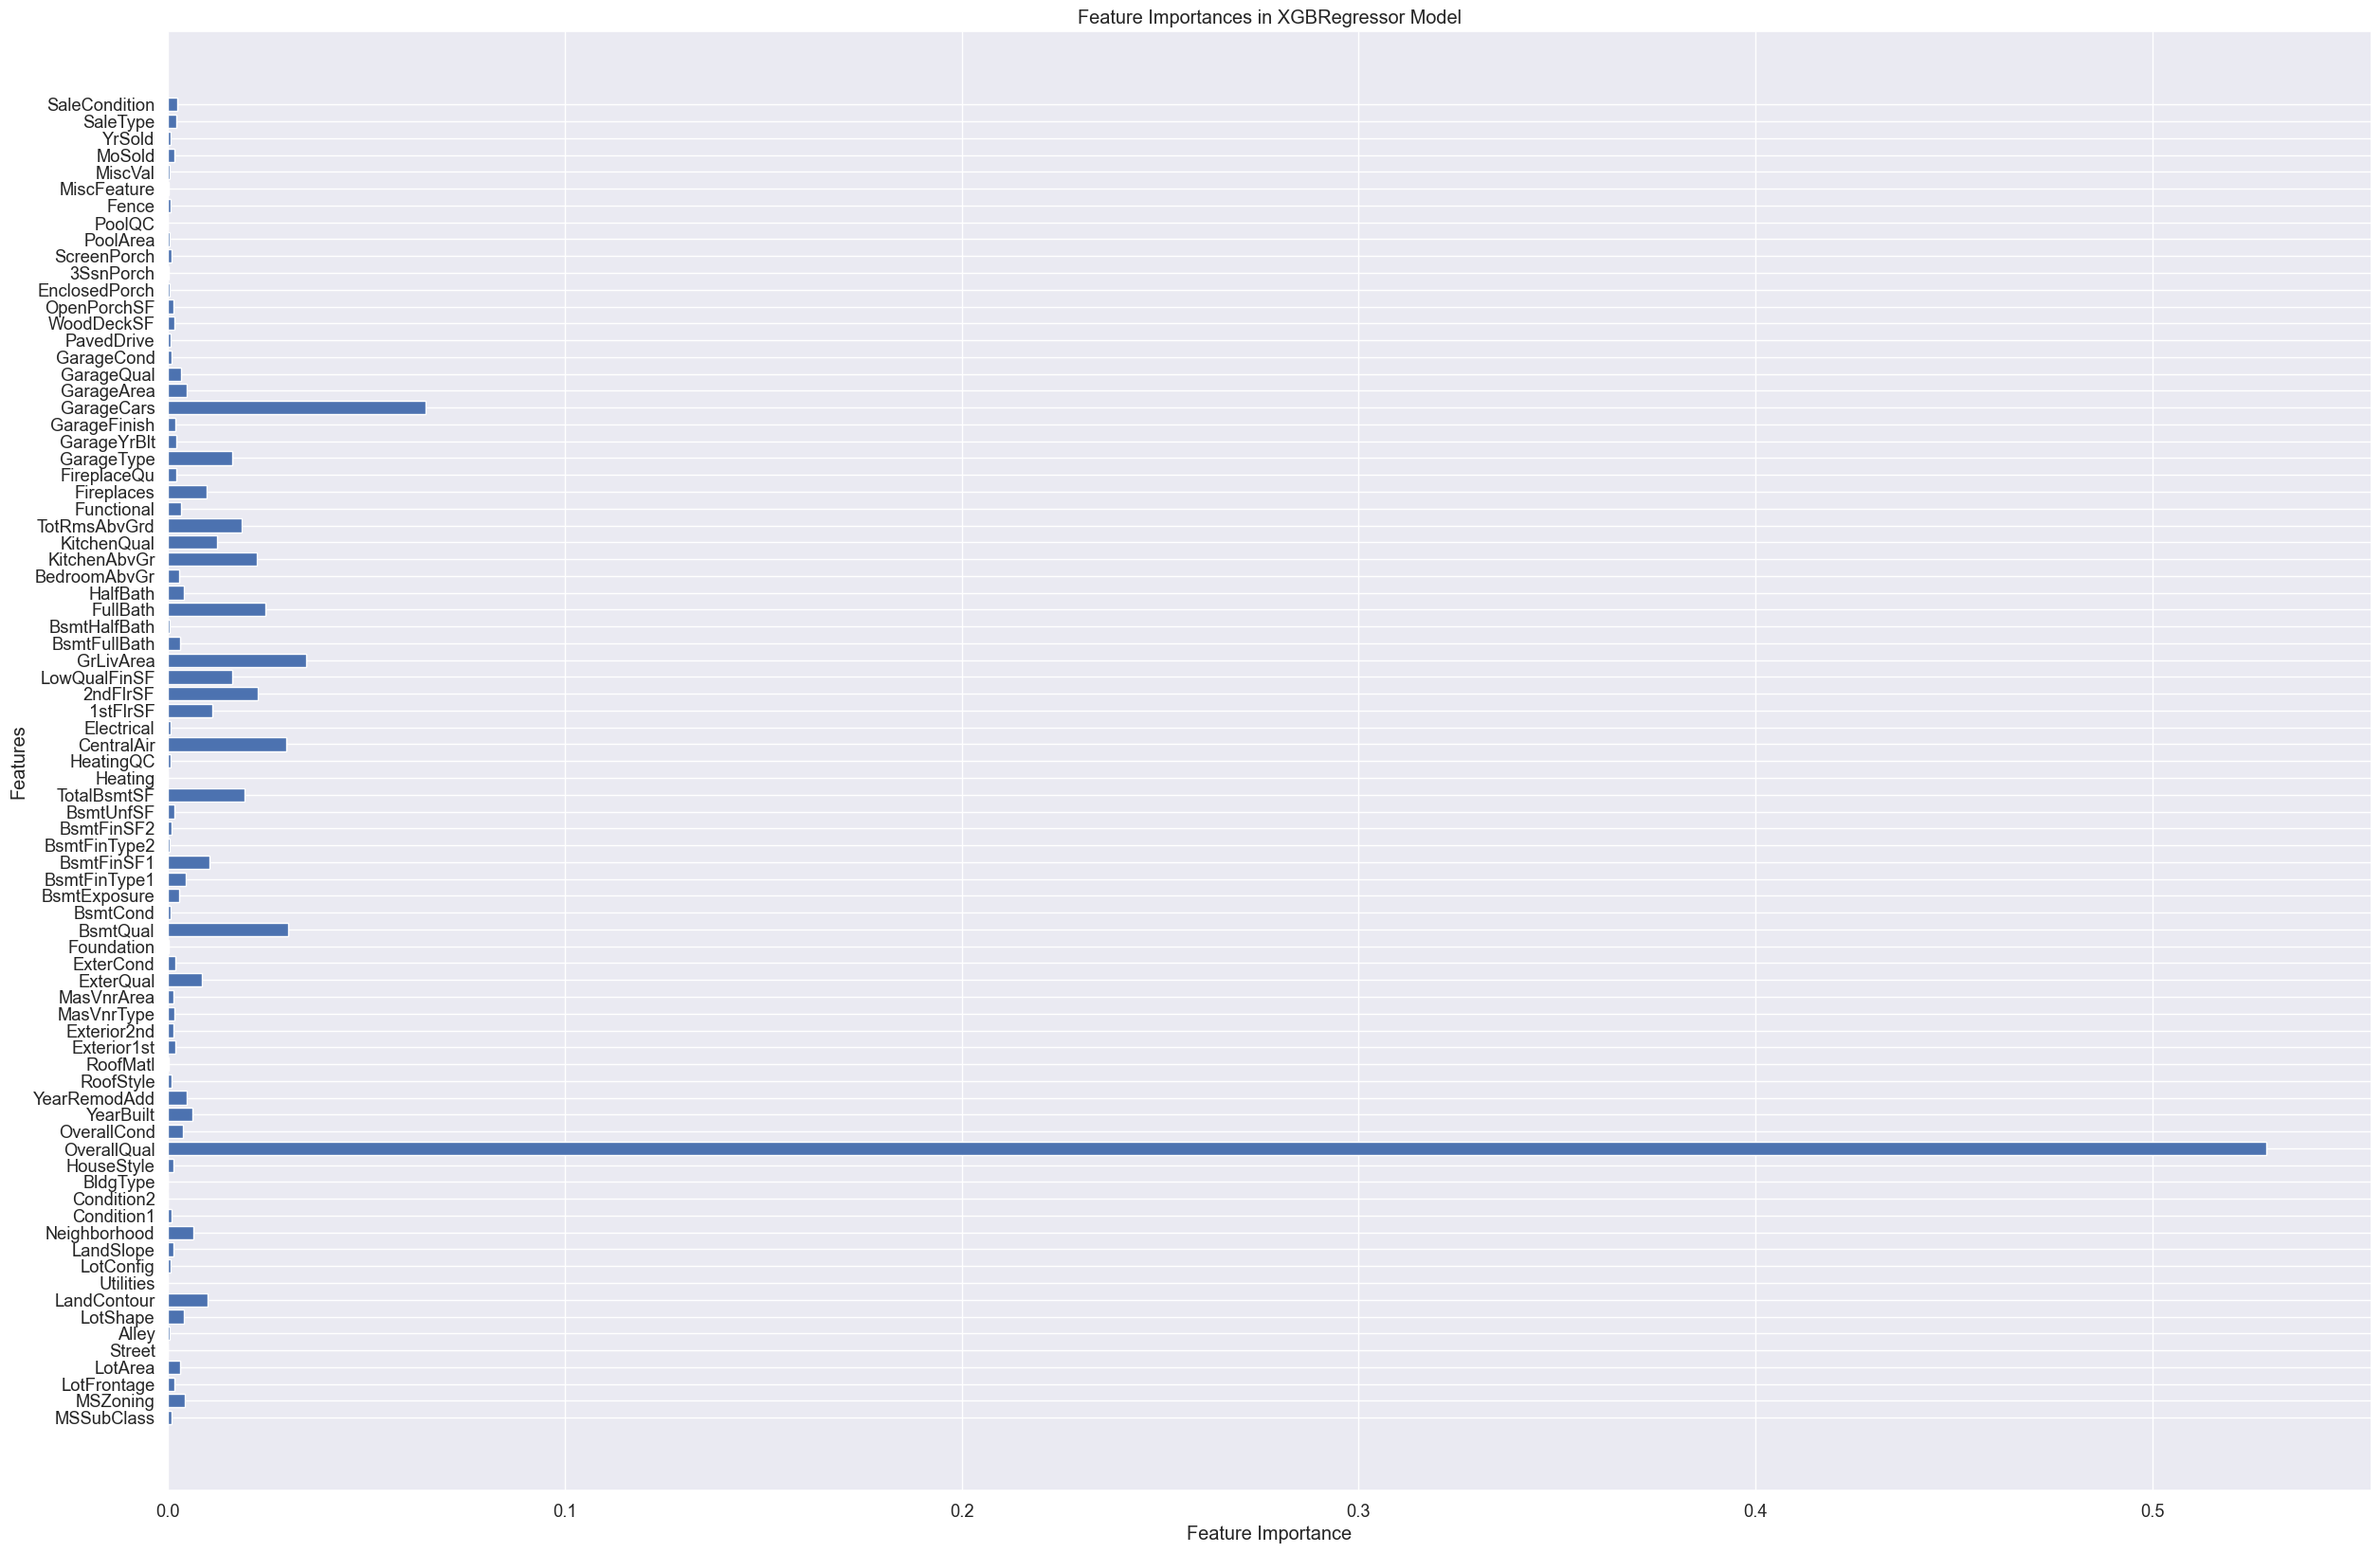

<Figure size 3000x10000 with 0 Axes>

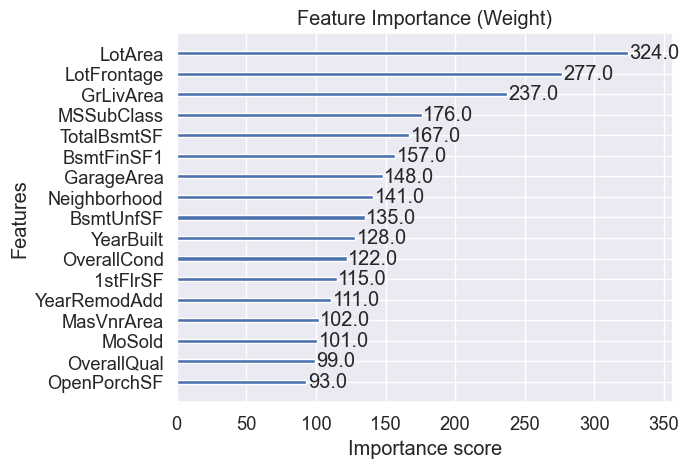

<Figure size 3000x10000 with 0 Axes>

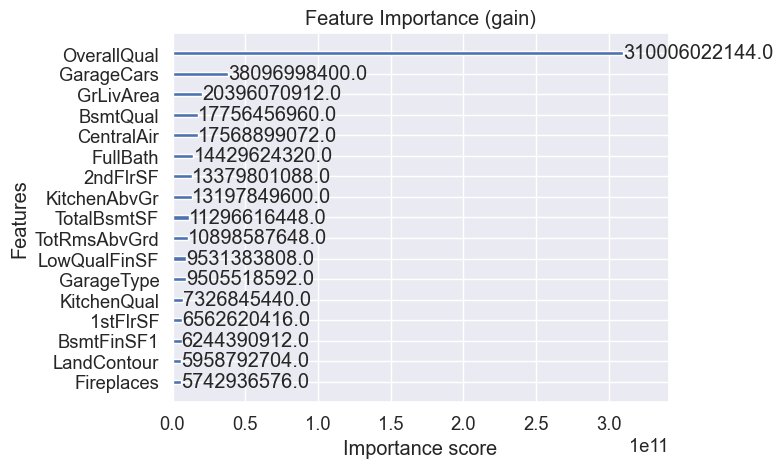

<Figure size 3000x10000 with 0 Axes>

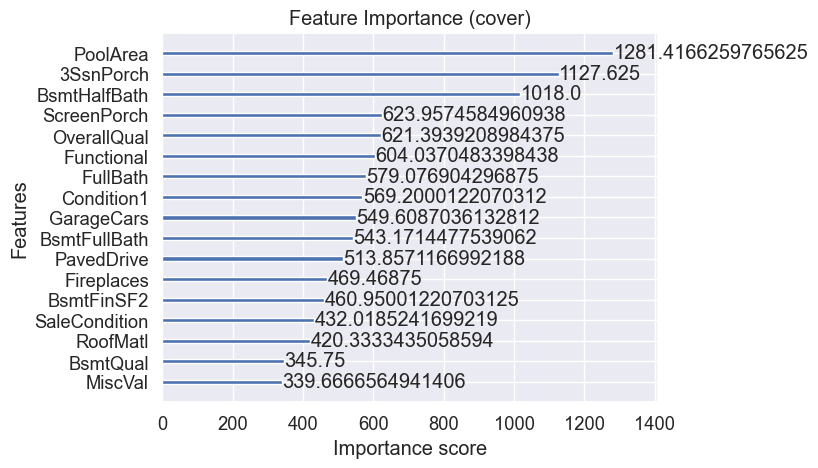

MSSubClass  importance (weight): 0.0009925794
MSZoning  importance (weight): 0.0009925794
LotFrontage  importance (weight): 0.0009925794
LotArea  importance (weight): 0.0009925794
Street  importance (weight): 0.0009925794
Alley  importance (weight): 0.0009925794
LotShape  importance (weight): 0.0009925794
LandContour  importance (weight): 0.0009925794
Utilities  importance (weight): 0.0009925794
LotConfig  importance (weight): 0.0009925794
LandSlope  importance (weight): 0.0009925794
Neighborhood  importance (weight): 0.0009925794
Condition1  importance (weight): 0.0009925794
Condition2  importance (weight): 0.0009925794
BldgType  importance (weight): 0.0009925794
HouseStyle  importance (weight): 0.0009925794
OverallQual  importance (weight): 0.0009925794
OverallCond  importance (weight): 0.0009925794
YearBuilt  importance (weight): 0.0009925794
YearRemodAdd  importance (weight): 0.0009925794
RoofStyle  importance (weight): 0.0009925794
RoofMatl  importance (weight): 0.0009925794
Exter

In [177]:
!pip install xgboost
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, random_state=38)
train_X = train_data[Inputs].apply(pd.to_numeric, errors='coerce')
train_y = train_data[Output].apply(pd.to_numeric, errors='coerce').values.ravel()

XGBmodel = XGBRegressor(objective='reg:squarederror', eta = 0.1, random_state=42)



#scale data
scaler = StandardScaler()
# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.transform(test_X)


# 5. Make predictions on the test data
XGBmodel.fit(train_X, train_y)
y_pred = XGBmodel.predict(test_X)


# 6. Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(test_y, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 7. Optionally, you can also calculate R-squared (R²) to evaluate the model fit
r2 = XGBmodel.score(test_X, test_y)
print(f"R-squared: {r2:.4f}")

# Step 6: Plot true values vs. predicted values (for R² visualization)
plt.figure(figsize=(8, 6))
plt.scatter(test_y, y_pred, color='blue', alpha=0.5, label='Predicted vs. True')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'R² = {r2:.4f}')
plt.legend()
plt.show()

feature_names = test_X.columns

# 8. Plot feature importances

# Get raw feature importances
raw_importances = XGBmodel.feature_importances_

# Normalize the importances (divide by the sum of all importances)
normalized_importances = raw_importances / raw_importances.sum()

plt.figure(figsize=(30, 20))
plt.barh(range(len(normalized_importances)), normalized_importances)
plt.yticks(range(len(normalized_importances)), train_X.columns)  # Set y-ticks to feature names
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances in XGBRegressor Model")
plt.show()
#This importance is based on the total amount of information each feature contributed to the model’s performance. 
#Specifically, it is calculated as the sum of the improvement brought by each feature to the splits in all trees.



#Plot feature importance using plot_importance, which is normalized data 
plt.figure(figsize=(30, 100))
plot_importance(XGBmodel, importance_type='weight', max_num_features=17, title="Feature Importance (Weight)")
plt.show()


#Plot feature importance using plot_importance, which is normalized data (GAIN)
plt.figure(figsize=(30, 100))
plot_importance(XGBmodel, importance_type='gain', max_num_features=17, title="Feature Importance (gain)")
plt.show()

#Plot feature importance using plot_importance, which is normalized data (GAIN)
plt.figure(figsize=(30, 100))
plot_importance(XGBmodel, importance_type='cover', max_num_features=17, title="Feature Importance (cover)")
plt.show()

#Extract the feature importances manually (for further analysis)
importances = XGBmodel.feature_importances_
count2 = 0
for features in feature_names:
    print(features, " importance (weight):", importances[count2])
    count += 1


Feature Distribution (Per feature), Heatmap of feature v feature correlation, and Feature importance graph using built-in feature importance function


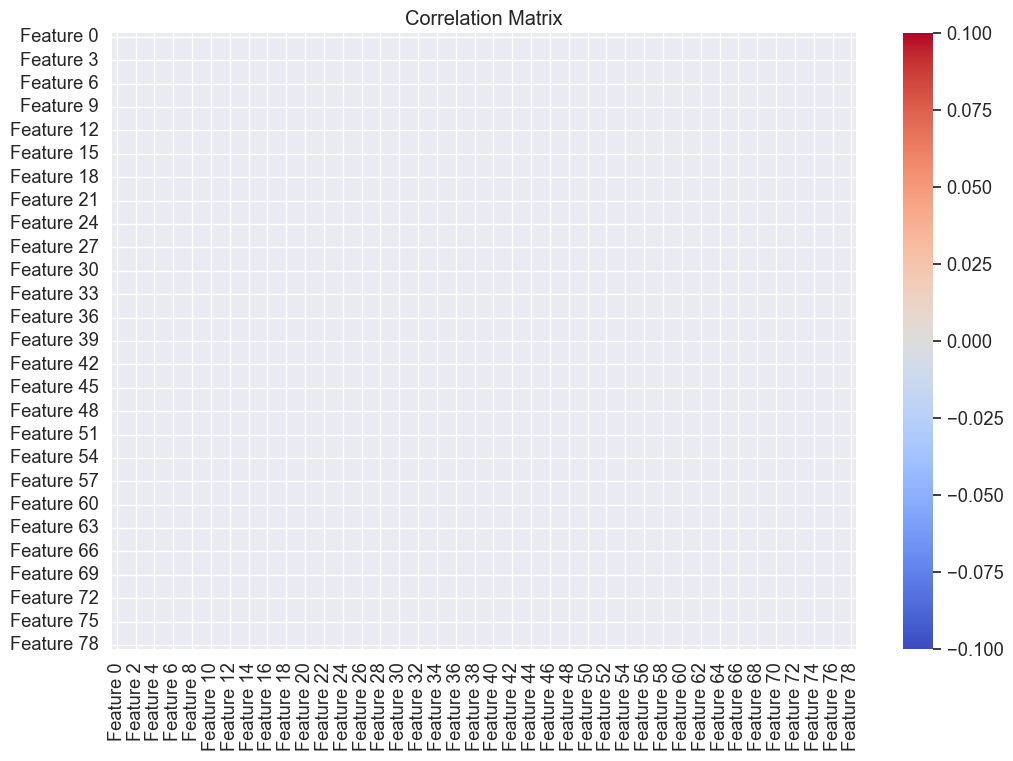

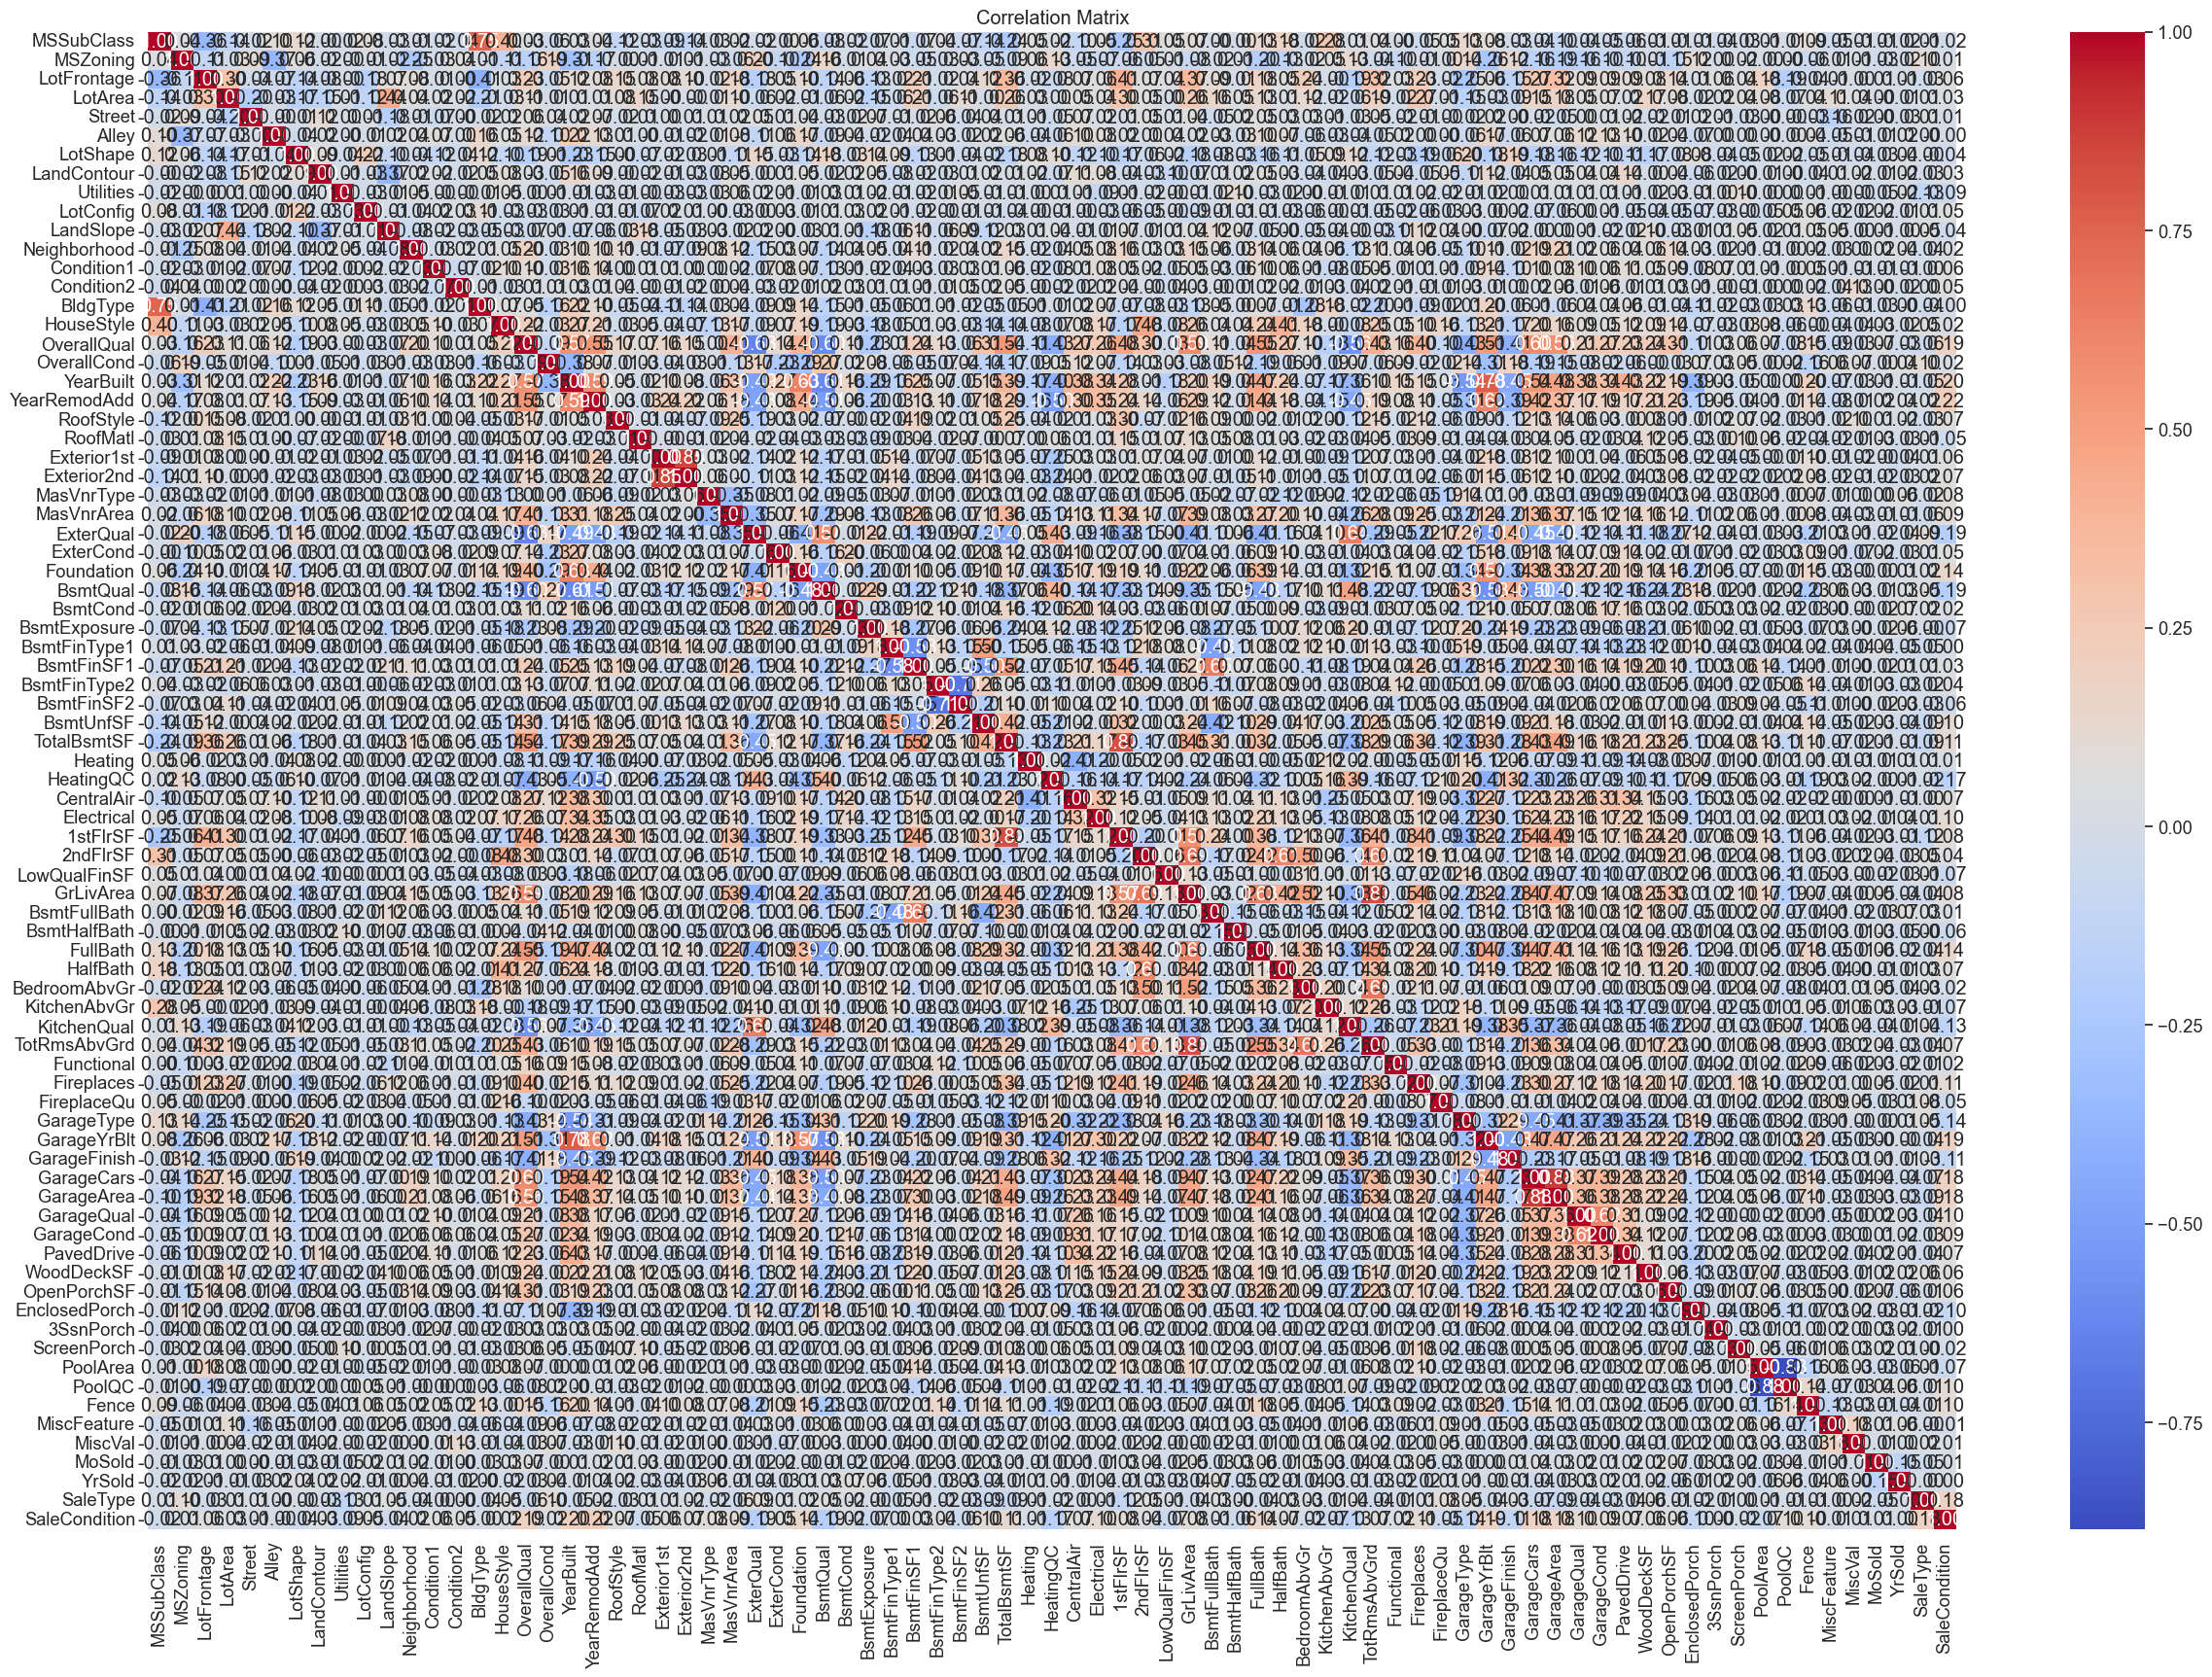

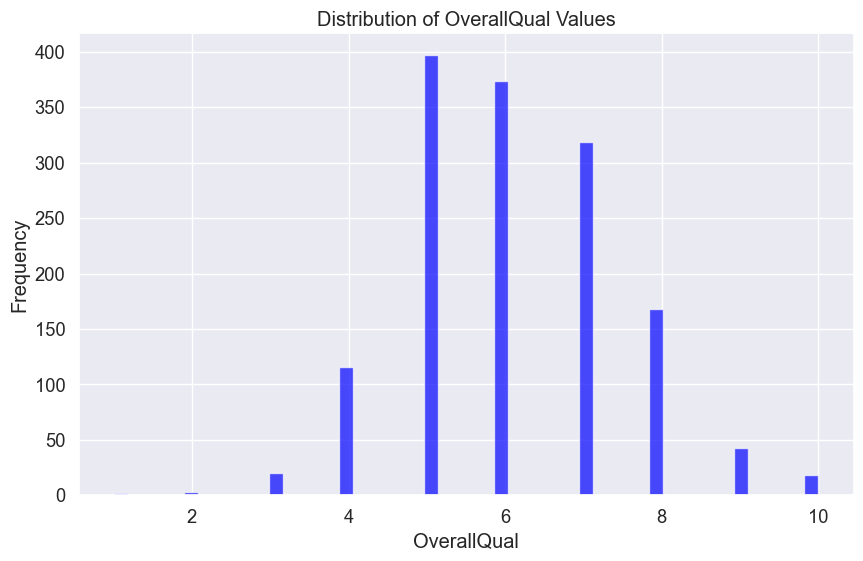

In [162]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Plot the correlation matrix
# Create a DataFrame with your features
df = pd.DataFrame(train_X, columns=[f"Feature {i}" for i in range(train_X.shape[1])])
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()
#-----------------------------------------------------------------
#Better heatmap
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)

# Convert train_X_scaled (numpy array) into a DataFrame with proper column names
df = pd.DataFrame(train_X_scaled, columns=train_X.columns)

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()
#-------------------------------------------------------------------
#feature distribution
feature_index = 16
feature_name = train_X.columns[feature_index]  # Get the column name

#feature_index = 16 is Overall Quality feature

# Plot the distribution of the feature
plt.figure(figsize=(10, 6))
plt.hist(train_X[feature_name], bins=50, color='blue', alpha=0.7)
plt.title(f"Distribution of {feature_name} Values")
plt.xlabel(f"{feature_name}")
plt.ylabel("Frequency")
plt.show()